# load packages

In [1]:
import warnings
warnings.filterwarnings("ignore")
import logging
logging.basicConfig(level=logging.WARNING)
import os
import random
import importlib
importlib.invalidate_caches()
import tensorflow as tf
tf.compat.v1.reset_default_graph()
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
import anndata as ad
import pandas as pd
import numpy as np
import scanpy as sc
from scipy.sparse import csr_matrix
from scipy.spatial import distance
from matplotlib.patches import Wedge
from matplotlib.collections import PatchCollection
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
from AddaGCN import AddaGCN_API

def visualize_pie(proportion, spatial_location, colors=None, radius=None, seed=None):
    # Convert inputs to DataFrames
    res_results = pd.DataFrame(proportion)
    res_results = res_results.reindex(sorted(res_results.columns), axis=1)  # Equivalent to mixedsort
    
    location = pd.DataFrame(spatial_location)
    
    # Check if row names match
    if not res_results.index.equals(location.index):
        raise ValueError("The rownames of proportion data does not match with the rownames of spatial location data")
    
    # Define color candidates (same as in R code)
    colorCandidate = [
        "#1e77b4", "#ff7d0b", "#ceaaa3", "#2c9f2c", "#babc22", "#d52828", "#9267bc",
        "#8b544c", "#e277c1", "#d42728", "#adc6e8", "#97df89", "#fe9795", "#4381bd",
        "#f2941f", "#5aa43a", "#cc4d2e", "#9f83c8", "#91675a", "#da8ec8", "#929292",
        "#c3c237", "#b4e0ea", "#bacceb", "#f7c685", "#dcf0d0", "#f4a99f", "#c8bad8",
        "#F56867", "#FEB915", "#C798EE", "#59BE86", "#7495D3", "#D1D1D1", "#6D1A9C",
        "#15821E", "#3A84E6", "#997273", "#787878", "#DB4C6C", "#9E7A7A", "#554236",
        "#AF5F3C", "#93796C", "#F9BD3F", "#DAB370", "#877F6C", "#268785", "#f4f1de",
        "#e07a5f", "#3d405b", "#81b29a", "#f2cc8f", "#a8dadc", "#f1faee", "#f08080"
    ]
    
    # Handle colors
    if colors is None:
        if len(res_results.columns) > len(colorCandidate):
            # Create a color palette if needed
            cmap = plt.cm.get_cmap('Spectral')
            colors = [mcolors.rgb2hex(cmap(i)) for i in np.linspace(0, 1, len(res_results.columns))]
        else:
            if seed is not None:
                random.seed(seed)
            colors = random.sample(colorCandidate, len(res_results.columns))
    else:
        colors = colors
    
    # Combine data
    data = pd.concat([res_results, location], axis=1)
    ct_select = res_results.columns.tolist()
    
    # Calculate radius if not provided
    if radius is None:
        x_range = data['x'].max() - data['x'].min()
        y_range = data['y'].max() - data['y'].min()
        area = x_range * y_range
        radius = np.sqrt((area / len(data)) / np.pi) * 0.7
    else:
        radius = radius
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create pie charts for each point
    for idx, row in data.iterrows():
        x, y = row['x'], row['y']
        proportions = row[ct_select].values
        proportions = proportions / proportions.sum()  # Normalize
        
        # Calculate cumulative sums for wedge angles
        cumsum = np.cumsum(proportions)
        cumsum = np.insert(cumsum, 0, 0)
        
        # Create wedges
        wedges = []
        for i in range(len(proportions)):
            theta1 = cumsum[i] * 360
            theta2 = cumsum[i+1] * 360
            wedge = Wedge((x, y), radius, theta1, theta2, facecolor=colors[i])
            wedges.append(wedge)
        
        # Add wedges to plot
        pc = PatchCollection(wedges, match_original=True, edgecolor='none')
        ax.add_collection(pc)
    
    # Set aspect ratio
    ax.set_aspect('equal')
    
    # Set plot limits
    x_margin = (data['x'].max() - data['x'].min()) * 0.1
    y_margin = (data['y'].max() - data['y'].min()) * 0.1
    ax.set_xlim(data['x'].min() - x_margin, data['x'].max() + x_margin)
    ax.set_ylim(data['y'].min() - y_margin, data['y'].max() + y_margin)
    
    # Customize plot appearance
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Create legend
    legend_patches = [plt.Rectangle((0,0), 1, 1, fc=color) for color in colors]
    ax.legend(legend_patches, ct_select, title='Cell Type', 
              bbox_to_anchor=(1.05, 1), loc='upper left', 
              borderaxespad=0., frameon=False)
    
    plt.tight_layout()
    return fig, ax

2025-04-22 17:41:01.984661: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2025-04-22 17:41:01.991113: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:16:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.52GHz coreCount: 128 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 938.86GiB/s
2025-04-22 17:41:01.991261: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:34:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.52GHz coreCount: 128 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 938.86GiB/s
2025-04-22 17:41:01.991392: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 2 with properties: 
pciBusID: 0000:ac:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.52GHz coreCount: 128 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 9

# load Data

This tutorial demonstrates AddaGCN's ablility to accurate and robust decomposition of cell-type compositions in seqFISH+ dataset.

In this tutorial, The original seqFISH+ dataset was from GSE98674 and correspond scRNA-seq dataset is collected from GSE60361.

We use seqFISH+ simulation data obtained from SpatialDWLS (https://doi.org/10.1186/s13059-021-02362-7), which can be obtained from https://github.com/rdong08/spatialDWLS_dataset/tree/main/datasets/simulate_data_seqFISH_plus.

In [2]:
input_dir = os.path.join('../AddaGCN')
os.chdir(input_dir)

# sp data   SpatialDWLS
counts_sp = pd.read_csv("Data/seqFISH+/simulate_data_seqFISH_plus/simulated_seqFISH_grid_norm_exp.txt", 
                        sep='\t', index_col=0).T
name = []
for i in list(counts_sp.index):
    a = i.split('_')
    b = [int(num) for num in a]
    name.append(b)

adata_sp = ad.AnnData(counts_sp)
adata_sp.X = csr_matrix(adata_sp.X)
adata_sp.obsm['spatial'] = np.array(name)
counts_t = pd.read_csv("Data/seqFISH+/simulate_data_seqFISH_plus/groudtruth_cell_percentage.txt", 
                        sep='\t', index_col=0)
set(counts_t.index == counts_sp.index)
adata_sp.obsm['truth'] = counts_t.values

# sc data
counts_sc = pd.read_csv("Data/seqFISH+/simulate_data_seqFISH_plus/raw_somatosensory_sc_exp.txt", sep='\t', index_col=0)
adata_sc = ad.AnnData(counts_sc.T)
adata_sc.X = csr_matrix(adata_sc.X)
sc_meta = pd.read_csv('Data/seqFISH+/simulate_data_seqFISH_plus/somatosensory_sc_labels.txt', sep='\t', header=None)
adata_sc.obs['cellType'] = sc_meta.iloc[:, 0].to_numpy()
adata_sc.var_names_make_unique()

inter_gene = list(set(adata_sp.var_names)&set(adata_sc.var_names))
adata_sp = adata_sp[:,inter_gene]
adata_sc = adata_sc[:,inter_gene]

# train model

In [3]:
AddaGCN = AddaGCN_API(adata_sp, adata_sc, num_markers=20, 
                      n_samples=400,  nmix=4, 
                      sample_iter = 4,  ct_unm_fix = 2,
                      celltype = 'cellType', sp= 'spatial')
AddaGCN.Train_(loss_weight = [0.1, 1], epochs=1000, lr=[0.001,0.001],  
               initial_train_epochs=10, emb_dim=64,
               initial_train = True,enable_dann = True)

... marker gene ...
6543400 (1691, 9962)
5167695.0 (1691, 9962)
2390689.8 (1691, 9962)
-72105.59 (1691, 9962)
... pseudo ...
... Pseudo number ...
Fixed number : 204
Unfixed number : 196
94152.8415216127 (71, 120)
88725.09349776697 (71, 120)
15414.98617846553 (71, 120)
3.979039320256561e-13 (71, 120)
124235.60412640871 (400, 120)
107977.66294485387 (400, 120)
37064.51706205634 (400, 120)
-2.4513724383723456e-13 (400, 120)
... Graph ...
------Calculating spatial graph...
... Calculating A matrix ...
<class 'numpy.matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'numpy.ndarray'>


2025-04-14 22:16:29.140514: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2025-04-14 22:16:29.155970: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 1896000000 Hz
2025-04-14 22:16:29.162941: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7b74000b70 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-04-14 22:16:29.162965: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-04-14 22:16:29.257242: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4476060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-14 22:16:29.257302: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-04-14 22:16:29.258187: I tensorf

initial_train_done
Epoch: 0000 train_loss= 1.7458 train_acc= 0.6512 val_loss= 1.7485 val_acc= 0.7778 test_loss= 1.7478 test_acc= 0.6250 time= 0.3538
Epoch: 0200 train_loss= 1.4914 train_acc= 0.7531 val_loss= 1.5437 val_acc= 0.8611 test_loss= 1.4196 test_acc= 0.8000 time= 0.0342
Epoch: 0400 train_loss= 1.4615 train_acc= 0.7593 val_loss= 1.5289 val_acc= 0.8889 test_loss= 1.3796 test_acc= 0.8750 time= 0.1414
Epoch: 0600 train_loss= 1.4079 train_acc= 0.8056 val_loss= 1.4685 val_acc= 0.8056 test_loss= 1.3486 test_acc= 0.9250 time= 0.1424
Epoch: 0800 train_loss= 1.3622 train_acc= 0.8457 val_loss= 1.4087 val_acc= 0.8056 test_loss= 1.3025 test_acc= 0.9500 time= 0.1264


# point plot
Prediction results of AddaGCN

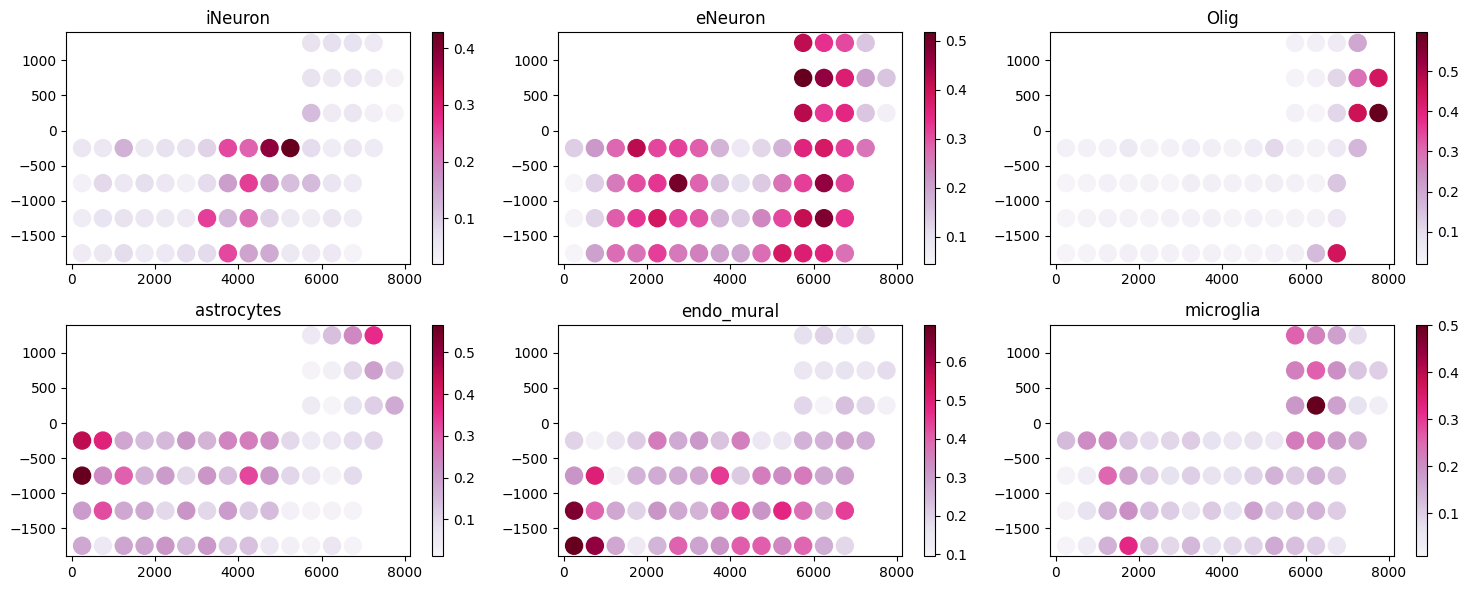

In [4]:
label = ['iNeuron', 'eNeuron', 'Olig', 'astrocytes', 'endo_mural', 'microglia']

pred_real = AddaGCN.adata_sp.obs[label]
spot_x = np.array(AddaGCN.adata_sp.obsm['spatial'][:, 0])
spot_y = np.array(AddaGCN.adata_sp.obsm['spatial'][:, 1])
a = 2
b = 3
fig, axs = plt.subplots(a, b, figsize=(15, 6))
num_labels = len(label)
for i in range(a):
    for j in range(b):
        index = i * b + j
        if index < num_labels:
            cell1 = np.array(pred_real[label[i * b + j]])
            a_ = axs[i, j].scatter(spot_x, spot_y, s=150, cmap='PuRd', c=cell1)  # 'viridis';'bwr';'cool';'PuRd';'Greys';'Purples';'Blues'
            fig.colorbar(a_, ax=axs[i, j])
            axs[i, j].set_title(label[i * b + j])
        else:
            axs[i, j].axis('off')
plt.tight_layout()
plt.show()

Grouth truth of AddaGCN

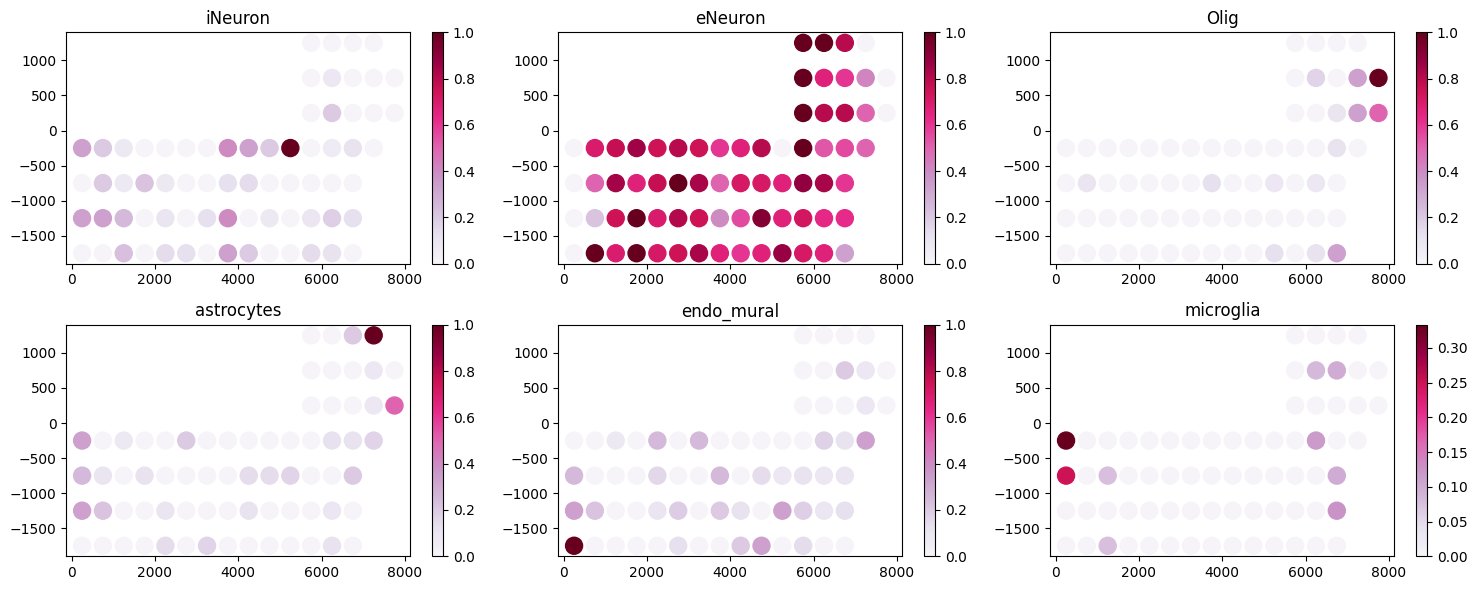

In [5]:
# ground_truth
ground_truth = pd.DataFrame(adata_sp.obsm['truth'])
ground_truth.columns = ['iNeuron', 'eNeuron', 'OPC', 'Olig', 'astrocytes', 'endo_mural', 'microglia']
ground_truth = ground_truth[label]

spot_x = np.array(AddaGCN.adata_sp.obsm['spatial'][:, 0])
spot_y = np.array(AddaGCN.adata_sp.obsm['spatial'][:, 1])
a = 2
b = 3
fig, axs = plt.subplots(a, b, figsize=(15, 6))
num_labels = len(label)
for i in range(a):
    for j in range(b):
        index = i * b + j
        if index < num_labels:
            cell1 = np.array(ground_truth[label[i * b + j]])
            a_ = axs[i, j].scatter(spot_x, spot_y, s=150, cmap='PuRd', c=cell1)  # 'viridis';'bwr';'cool';'PuRd';'Greys';'Purples';'Blues'
            fig.colorbar(a_, ax=axs[i, j])
            axs[i, j].set_title(label[i * b + j])
        else:
            axs[i, j].axis('off')
plt.tight_layout()
plt.show()

# pie plot

In [6]:
label = ['microglia', 'astrocytes', 'endo_mural', 'eNeuron', 'iNeuron', 'Olig']
adata_pseudo = AddaGCN.adata_pseudo.copy()
adata_sp = AddaGCN.adata_sp.copy()
# label = ['endo_mural', 'microglia', 'iNeuron', 'astrocytes', 'eNeuron', 'Olig']
pred_real = adata_sp.obs[label]

location = pd.DataFrame(AddaGCN.adata_sp.obsm['spatial'])
pred_real.index = location.index
location.columns = ['x', 'y']

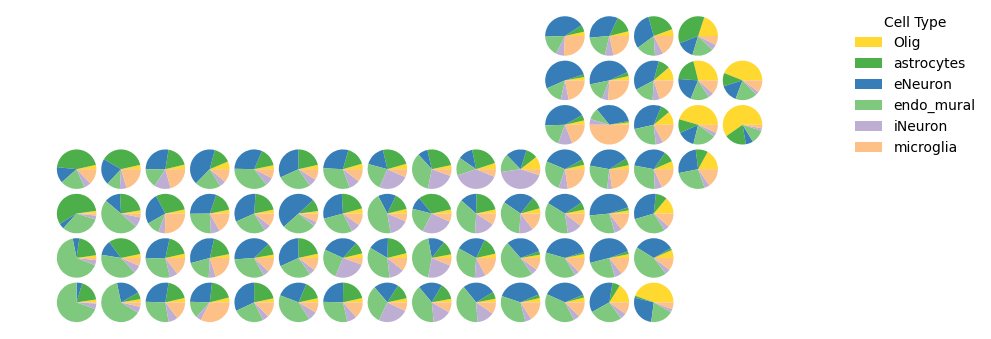

In [7]:
coler_len = len(pred_real.columns)
colors = ["#FFD92F","#4DAF4A","#377EB8","#7FC97F","#BEAED4","#FDC086","#FFFF99","#386CB0","#F0027F",
           "#BF5B17","#666666","#1B9E77","#D95F02","#7570B3","#E7298A","#66A61E","#E6AB02","#A6761D","#9E0142","#D53E4F"]


fig, ax = visualize_pie(pred_real, location, colors[:coler_len])
plt.show()

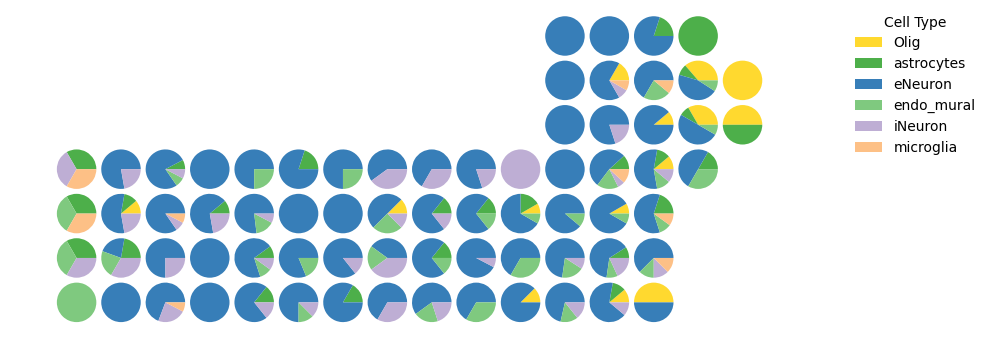

In [8]:
# ground_truth
ground_truth = pd.DataFrame(adata_sp.obsm['truth'])
ground_truth.columns = ['iNeuron', 'eNeuron', 'OPC', 'Olig', 'astrocytes', 'endo_mural', 'microglia']
ground_truth = ground_truth[label]

fig, ax = visualize_pie(ground_truth, location, colors[:coler_len])
plt.show()